# Practical Session on Graph Neural Networks


Authors: GOMEZ, Diego, REGUEIRO ESPIÑO Ramón Daniel, SALAZAR, Israfel

email: {diego.gomez, ramon.regueiro_espino, israfel.salazar} @ens-paris-saclay.fr

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 37.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.7/874.7 KB 11.7

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [ ]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [ ]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [ ]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [ ]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [ ]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6387
F1-Score: 0.4517
Epoch 00002 | Loss: 0.5820
Epoch 00003 | Loss: 0.5624
Epoch 00004 | Loss: 0.5556
Epoch 00005 | Loss: 0.5511
Epoch 00006 | Loss: 0.5462
F1-Score: 0.4997
Epoch 00007 | Loss: 0.5418
Epoch 00008 | Loss: 0.5377
Epoch 00009 | Loss: 0.5344
Epoch 00010 | Loss: 0.5316
Epoch 00011 | Loss: 0.5292
F1-Score: 0.5267
Epoch 00012 | Loss: 0.5267
Epoch 00013 | Loss: 0.5242
Epoch 00014 | Loss: 0.5218
Epoch 00015 | Loss: 0.5196
Epoch 00016 | Loss: 0.5175
F1-Score: 0.5297
Epoch 00017 | Loss: 0.5154
Epoch 00018 | Loss: 0.5132
Epoch 00019 | Loss: 0.5111
Epoch 00020 | Loss: 0.5090
Epoch 00021 | Loss: 0.5067
F1-Score: 0.5147
Epoch 00022 | Loss: 0.5044
Epoch 00023 | Loss: 0.5021
Epoch 00024 | Loss: 0.5001
Epoch 00025 | Loss: 0.4982
Epoch 00026 | Loss: 0.4963
F1-Score: 0.5329
Epoch 00027 | Loss: 0.4944
Epoch 00028 | Loss: 0.4927
Epoch 00029 | Loss: 0.4908
Epoch 00030 | Loss: 0.4891
Epoch 00031 | Loss: 0.4873
F1-Score: 0.5486
Epoch 00032 | Loss: 0.4856
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6659


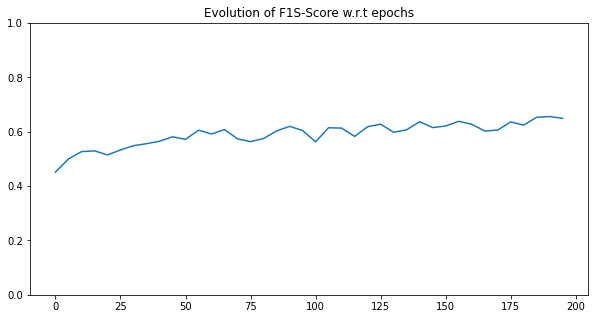

In [ ]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [ ]:
class GATModel(nn.Module):
    def __init__(self,
                 num_heads: int,
                 num_layers: int,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 dropout: float,
                 ):
        super().__init__()
        self.gats = nn.ModuleList()
        self.gats.append(
            graphnn.GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout))
        for i in range(num_layers):
            self.gats.append(
                graphnn.GATConv(hidden_dim*num_heads, hidden_dim, heads=num_heads, dropout=dropout)
                )
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim*num_heads, output_dim)

    def forward(self, x, adj):
        for i in range(len(self.gats)):
            x = self.gats[i](x, adj)
            x = self.relu(x)
        x = self.fc(x)
        print(x.shape)
        return x

In [ ]:
student_model = GATModel(
    num_heads=4,
    num_layers=2,
    input_dim=n_features,
    hidden_dim=200,
    output_dim=n_classes,
    dropout=0.1
    )

In [ ]:
for sample in train_dataloader:
    output = student_model(sample.x, sample.edge_index)
    break

torch.Size([3144, 121])


Let's train your model !

In [ ]:
## Student model
student_model = GATModel(
    num_heads=4,
    num_layers=2,
    input_dim=n_features,
    hidden_dim=200,
    output_dim=n_classes,
    dropout=0.1
    )

student_model.to(device=device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, 500, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.8289
F1-Score: 0.3936
Epoch 00002 | Loss: 0.5683
Epoch 00003 | Loss: 0.5547
Epoch 00004 | Loss: 0.5517
Epoch 00005 | Loss: 0.5471
Epoch 00006 | Loss: 0.5415
F1-Score: 0.4590
Epoch 00007 | Loss: 0.5387
Epoch 00008 | Loss: 0.5302
Epoch 00009 | Loss: 0.5391
Epoch 00010 | Loss: 0.5290
Epoch 00011 | Loss: 0.5243
F1-Score: 0.4934
Epoch 00012 | Loss: 0.5211
Epoch 00013 | Loss: 0.5234
Epoch 00014 | Loss: 0.5286
Epoch 00015 | Loss: 0.5194
Epoch 00016 | Loss: 0.5112
F1-Score: 0.4996
Epoch 00017 | Loss: 0.5082
Epoch 00018 | Loss: 0.5076
Epoch 00019 | Loss: 0.5022
Epoch 00020 | Loss: 0.4971
Epoch 00021 | Loss: 0.4946
F1-Score: 0.5097
Epoch 00022 | Loss: 0.4913
Epoch 00023 | Loss: 0.4885
Epoch 00024 | Loss: 0.4908
Epoch 00025 | Loss: 0.4916
Epoch 00026 | Loss: 0.4909
F1-Score: 0.5521
Epoch 00027 | Loss: 0.4882
Epoch 00028 | Loss: 0.4947
Epoch 00029 | Loss: 0.4933
Epoch 00030 | Loss: 0.4802
Epoch 00031 | Loss: 0.4751
F1-Score: 0.5447
Epoch 00032 | Loss: 0.4714
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9842


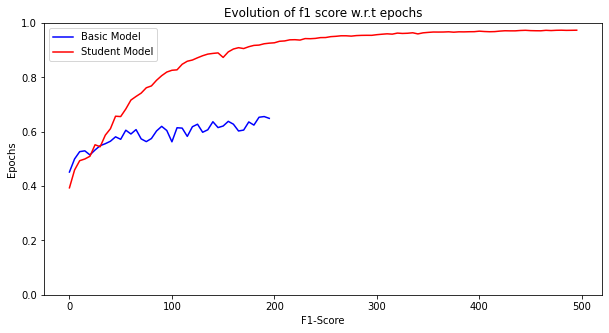

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list[:40], basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**

**1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).**

GCNLayer is a special case of GAT. This means that GAT can create richer representations of the train data. In GCNLayer we apply the same convolutional filter to all the graphs. Instead, GAT is based on the self-attention operation that computes the weights taking into account the relationship between the features. This weight computation process allows GAT to efficiently focus on the most significant nodes, resulting in a more effective and accurate graph layer.

**2. Analyze your results (what is the F1-Score)? Are your results convincing ? what is your position w.r.t state-of-the-art ?).**

The F1 score evaluates the performance of binary classification taking into account precision, a measure of the proportion of true positives among all the positive predictions, and recall, a measure of the proportion of true positives among all actual positive instances. It is the harmonic mean of precision and recall, with values closer to 1 indicating better performance. This score is specially useful for evaluating a model's performance when the dataset is imbalanced or when both false positives and false negatives are equally important.

We consider that the obtained performance of the model indicates a good model for this task. We achieved even a higher accuracy on the validation set than on the training set which implies that our model could even improve its results. We highlight that the obtained results using GAT are similar to the ones achieved in the original paper for this dataset (https://arxiv.org/pdf/1710.10903.pdf). It's also interesting to notice that the results presented with GAT are significantly better than the previous methods. We remark that nowadays there exist other models with similar or slightly better results, like it can be seen in https://arxiv.org/abs/2302.10506. However, these new models are often more complex, which might not justify the performance improvement.

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagram must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

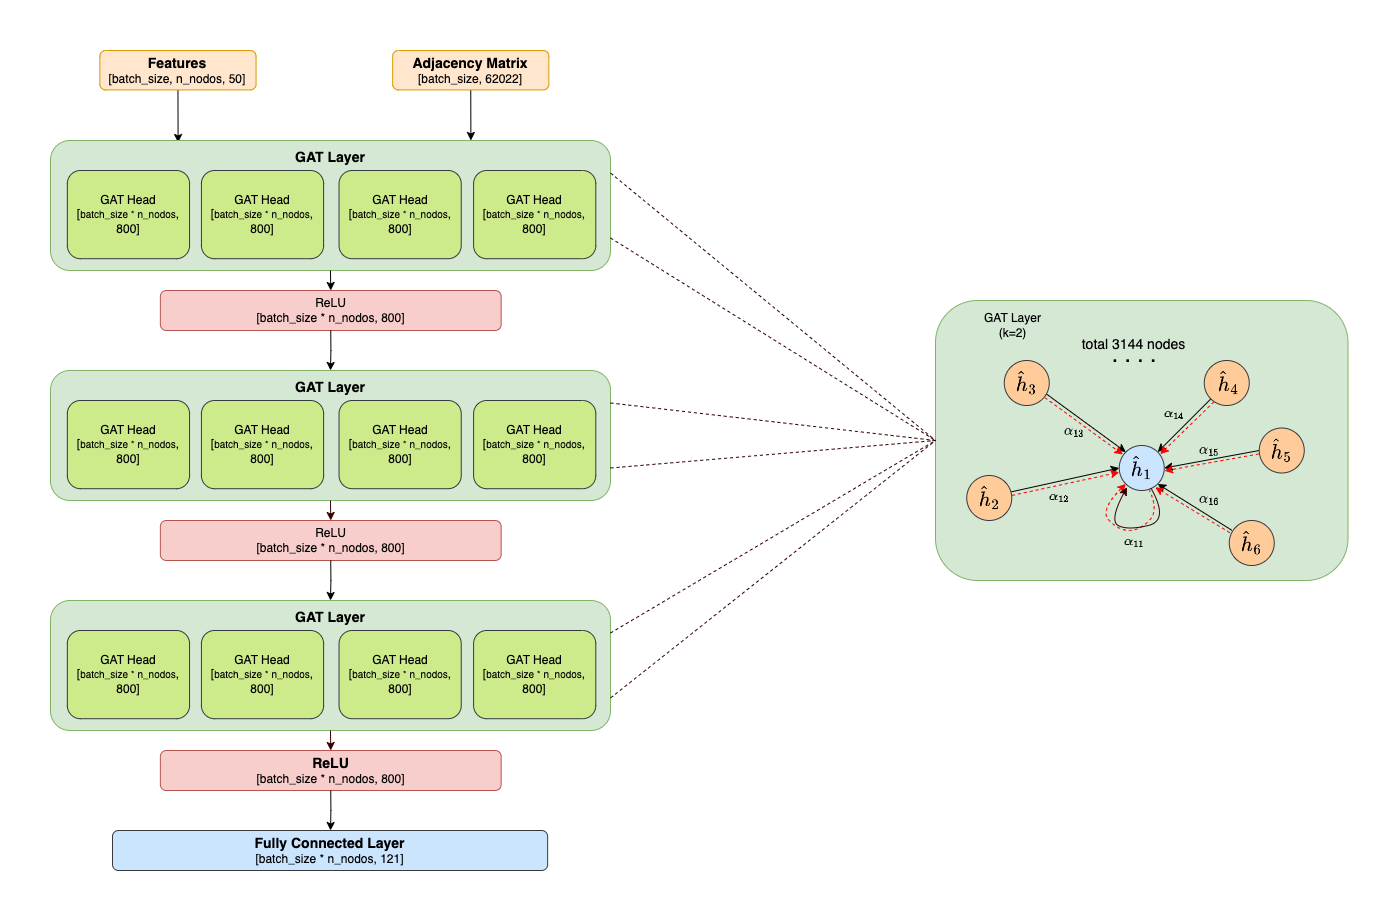

**3. Make a small paragraph that explains: (6pts)**

**1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?**

In the context of Graph Neural Networks (GNN) oversmoothing is the convergence of nodes in the graph to a same represenation. This can happen when adding more layers to the GNNs, since at each layer the model aggregates information. If this aggregation is done too many times, node representation can become too similar. This specially becomes an issue when nodes with different labels converge to similar representations. Indeed, this limits the discriminative power of the neural network. Solving this issue is not straight forward. If we use too many layers the oversmoothing phenomenon takes place. However, the receptive field of the GNN increases with the number of layers too, making a more expressive model. Therefore, the oversmoothing problem is a trade-off problem.

**2. Are there solutions to overcome it ?**

One way to alleviate this problem is to use more discriminative aggregation functions in each layer. That is, aggregation functions that do no treat all nodes in the same manner (e.g. mean, max). Simple ways to do so include adding elements like dropout and weight decay. For instance, dropout would change the nodes that are propagated to the next layer at each forward call, making it harder for many nodes to have the same representation.

Another more elaborate way to mitigate the oversmothing effect is the use of graph attention mechansisms. This is what we have done above. Graph attention mechanisms, such as the ones used in the The Graph Attention Network (GAT), control the flux of information between nodes with the use of attention coefficients. Since attention promotes the communication between relevant nodes one can see how this mechanism allows to mitigate the oversmoothing problem. Indeed, in the best case scenario we would only have communication between nodes of the same class. This would leave of all nodes of the same class to have the same representation, which is optimal to classify them.


**3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?**

The model we have constructed is more resistant to the oversmoothing problem than the basic model. Moreover, the model that we are using is small, just a couple of attention layers, so ideally this should help in robustness.  However, we cannot say that is it completly robust against it. This is mainly because the attention mechanism is also a learnable layer that is subject to classical deep learning problems. In principle attention helps the GNN model selectively propagate information between relevant nodes. However, if this selection is done poorly, due to overfitting for example, oversmoothing could still take place.